In [2]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import cbpro
from pathlib import Path
import seaborn as sns

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)
import requests
from creds import api_key

import tensorflow as tf
import tensorflow_probability as tfp
from pandasgui import show

tf.distribute.OneDeviceStrategy(device="/gpu:0")

public_client = cbpro.PublicClient()

In [12]:
def compile_lc_data(coins="ETH"):
    intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
    now = datetime.now()
    # delta = timedelta(num_days_in_past)
    # ut = datetime.timestamp((now - delta))

    payload = {
        "key": api_key,
        "symbol": coins,
        "change": intervals,
        "data_points": "720",
        # "start": ut,
        # "end": datetime.timestamp(now),
    }

    r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

    data = pd.DataFrame.from_dict(r.json()["data"][0])
    ts = data.timeSeries.to_dict()
    new = pd.DataFrame.from_dict(ts, orient="index")
    new.pop("asset_id")
    new.pop("search_average")
    new["time"] = pd.to_datetime(new["time"], unit="s")
    new.set_index("time", inplace=True)
    new.sort_index(ascending=True, inplace=True)
    new["month"] = [new.index[i].month for i in range(len(new))]
    new["day"] = [new.index[i].day for i in range(len(new))]
    new["hour"] = [new.index[i].hour for i in range(len(new))]
    new.fillna(new.mean(), inplace=True)

    return new


df = compile_lc_data()
print(df.isna().sum().sum())
print(df.index.max())
print(df.index.min())
df.tail()


0
2021-10-25 02:00:00
2021-09-25 02:00:00


,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,month,day,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-10-24 22:00:00,4085.662340,4079.725760,4094.561365,4068.585294,8.602205e+08,481859999851,1048,558,21.000000,578.000000,...,5563,0.066761,76105,7.309638,2799331593100,17.213395,-1.041745,10,24,22
2021-10-24 23:00:00,4084.577280,4089.943471,4093.582876,4071.707808,8.048015e+08,483044139744,938,567,21.000000,111.000000,...,4920,0.066948,76279,6.450006,2800013121624,17.251496,-1.989986,10,24,23
2021-10-25 00:00:00,4085.334886,4133.282319,4133.282319,4080.037022,1.287621e+09,487480424105,637,404,14.000000,40.000000,...,4376,0.066704,73820,5.927933,2826934430829,17.244136,-0.293419,10,25,0
2021-10-25 01:00:00,4134.778344,4121.577885,4143.036942,4119.042758,1.007774e+09,486148056958,592,353,8.000000,10.000000,...,3883,0.066582,68919,5.634150,2824049366929,17.214574,-0.389198,10,25,1
2021-10-25 02:00:00,4121.696454,4118.129175,4125.671900,4111.389993,3.985331e+08,486339193596,564,321,37.869263,471.899861,...,3557,0.066663,67448,5.273692,2813482504313,17.286022,-0.620000,10,25,2


In [4]:
train_ds = df.sample(frac=0.8, random_state=0)
test_ds = df.drop(train_ds.index)

train_features = train_ds.copy()
test_features = test_ds.copy()

train_label = train_features.pop("close")
test_labels = test_features.pop("close")


# ds = tf.data.Dataset.from_tensor_slices((features, label)).batch(32)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features).astype("float32"))

linear_model = tf.keras.models.Sequential([normalizer, tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam()

linear_model.compile(optimizer=optimizer, loss="mse")


In [5]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(58, 1) dtype=float32, numpy=
array([[ 0.23815352],
       [-0.02544767],
       [-0.03304353],
       [-0.04115921],
       [-0.27315253],
       [ 0.26317883],
       [ 0.20879573],
       [-0.25364333],
       [-0.2129153 ],
       [ 0.27471143],
       [ 0.04979038],
       [ 0.06550336],
       [-0.15983398],
       [-0.08304429],
       [ 0.25290102],
       [ 0.31320548],
       [ 0.13565314],
       [ 0.08512715],
       [-0.04118538],
       [ 0.11765939],
       [-0.00906265],
       [-0.05861825],
       [ 0.13299602],
       [ 0.20780736],
       [ 0.1352596 ],
       [-0.18796213],
       [-0.08846612],
       [-0.13224712],
       [-0.03055871],
       [ 0.31757802],
       [ 0.2937047 ],
       [-0.18014053],
       [-0.2500766 ],
       [-0.09222737],
       [ 0.31443208],
       [ 0.28617793],
       [ 0.071592  ],
       [ 0.01800358],
       [ 0.1721164 ],
       [-0.23166198],
       [-0.18101451],
       [-0.177013  ],
       [ 0

In [6]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, mode="min"
    )
history = linear_model.fit(
    train_features,
    train_label,
    epochs=20,
    validation_split=.2,
    callbacks=[early_stopping],
    
)

Epoch 1/20
15/15 [==============================] - 2s 30ms/step - loss: 12669672.0000 - val_loss: 12442895.0000
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 12669308.0000 - val_loss: 12442663.0000
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 12668974.0000 - val_loss: 12442408.0000
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 12668619.0000 - val_loss: 12442167.0000
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 12668290.0000 - val_loss: 12441921.0000
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 12667951.0000 - val_loss: 12441672.0000
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 12667613.0000 - val_loss: 12441428.0000
Epoch 8/20
15/15 [==============================] - 0s 9ms/step - loss: 12667275.0000 - val_loss: 12441172.0000
Epoch 9/20
15/15 [==============================] - 0s 9ms/step - loss: 12666912.0000 - val_loss: 1244

In [7]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()


,loss,val_loss,epoch
15,12664497.0,12439181.0,15
16,12664158.0,12438945.0,16
17,12663820.0,12438689.0,17
18,12663478.0,12438433.0,18
19,12663126.0,12438187.0,19


In [8]:
test_results = {}

test_results["linear_baseline"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)


In [9]:
def build_and_compile_model(norm):
    model = tf.keras.models.Sequential(
        [
            norm,
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(loss="mse", optimizer="adam")
    return model


In [10]:
dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 58)                117       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3776      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,118
Trainable params: 8,001
Non-trainable params: 117
_________________________________________________________________


In [11]:
%%time
history = dnn_model.fit(
    train_features,
    train_label,
    validation_split=0.2,
    epochs=2000, callbacks=[early_stopping])

Epoch 1/2000
15/15 [==============================] - 1s 16ms/step - loss: 12659872.0000 - val_loss: 12421151.0000
Epoch 2/2000
15/15 [==============================] - 0s 7ms/step - loss: 12636214.0000 - val_loss: 12392803.0000
Epoch 3/2000
15/15 [==============================] - 0s 6ms/step - loss: 12598687.0000 - val_loss: 12346445.0000
Epoch 4/2000
15/15 [==============================] - 0s 7ms/step - loss: 12537227.0000 - val_loss: 12270940.0000
Epoch 5/2000
15/15 [==============================] - 0s 7ms/step - loss: 12439171.0000 - val_loss: 12153223.0000
Epoch 6/2000
15/15 [==============================] - 0s 7ms/step - loss: 12287605.0000 - val_loss: 11977908.0000
Epoch 7/2000
15/15 [==============================] - 0s 7ms/step - loss: 12064461.0000 - val_loss: 11730662.0000
Epoch 8/2000
15/15 [==============================] - 0s 6ms/step - loss: 11755979.0000 - val_loss: 11393596.0000
Epoch 9/2000
15/15 [==============================] - 0s 7ms/step - loss: 11343882.0000

KeyboardInterrupt: 

<AxesSubplot:xlabel='epoch'>

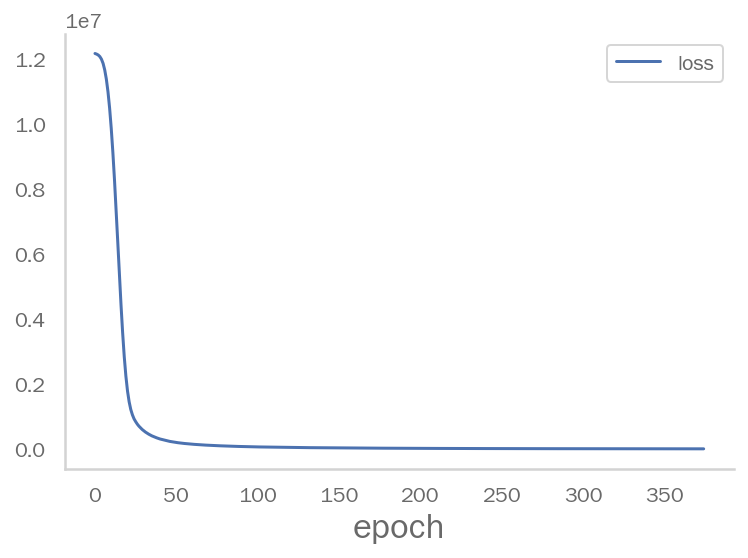

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.plot(x="epoch", y="loss")


In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

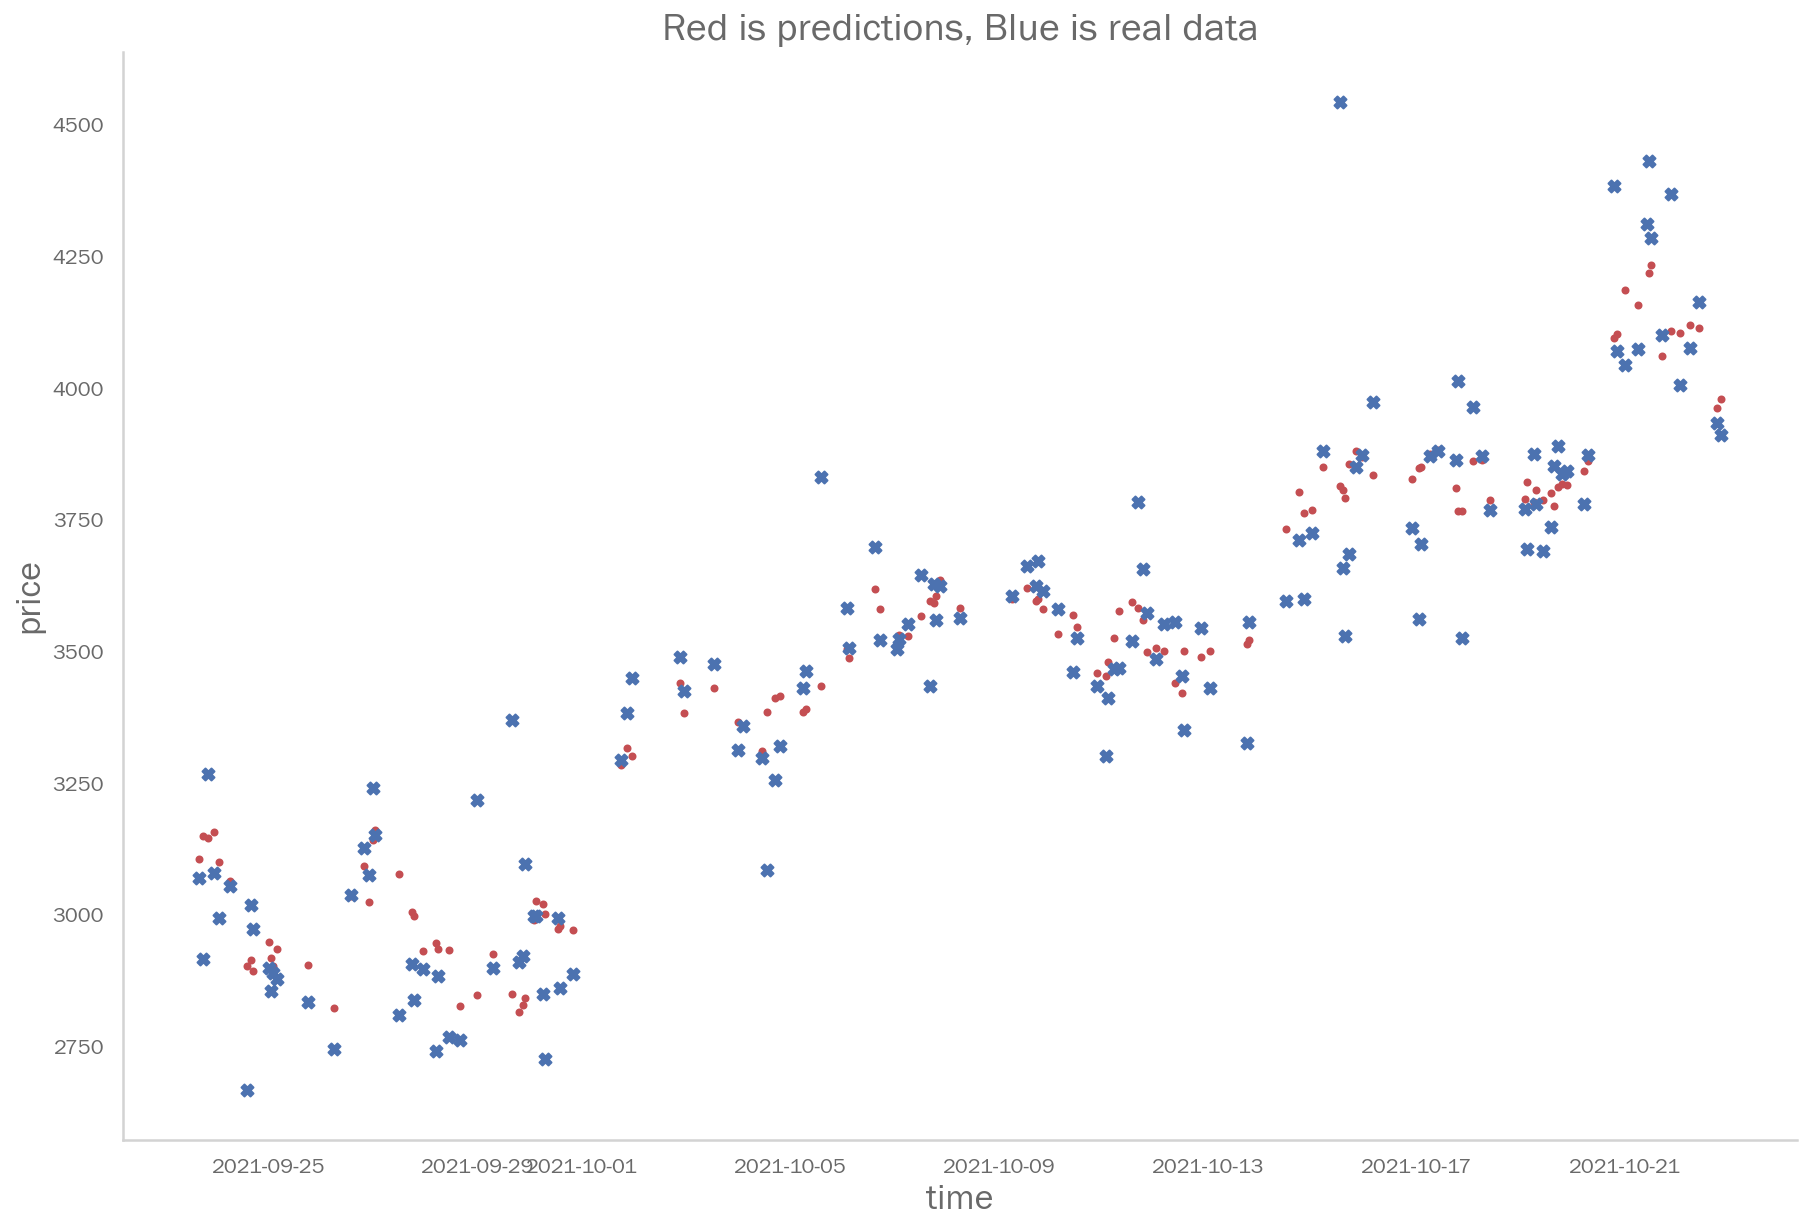

In [ ]:
def plot_result(labels, preds):
    plt.figure(figsize=(15, 10))
    plt.scatter(x=labels.index, y=labels, color="r", marker=".", label="real data")
    plt.scatter(x=labels.index, y=preds, color="b", marker="X", label="predictions")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.title("Red is predictions, Blue is real data")
    plt.show()


plot_result(test_labels, test_predictions)


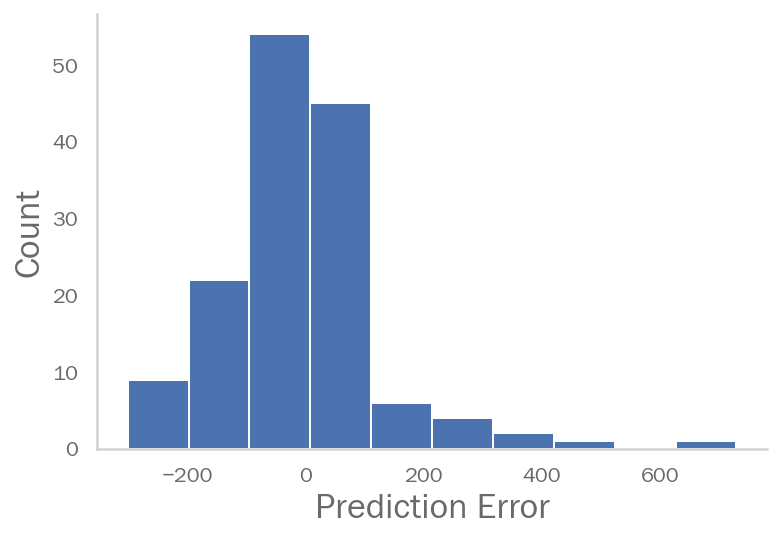

In [ ]:
error = test_predictions - test_labels
plt.hist(error)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')